In [448]:
import numpy as np
import pandas as pd 

import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization,Input,UpSampling2D
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import regularizers
import cv2
from tqdm import tqdm
import random
from skimage.io import imread
from skimage.transform import resize
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import *
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from keras.utils.vis_utils import plot_model
from IPython.display import Image
from keras import backend as K
import nltk
import re
from sentence_transformers import SentenceTransformer
from sklearn.metrics import pairwise_distances
import pickle

In [166]:
def preprocess_img(img_path):
    dsize = (img_width, img_height)
    new_image=cv2.imread(img_path)
    new_image=cv2.resize(new_image,dsize)  
    new_image=np.expand_dims(new_image,axis=0)
    new_image = new_image*(1./255)
    new_image=np.flip(new_image,axis=-1)
    return new_image

In [190]:
img_width = 256
img_height = 256

In [362]:
descriptions = pd.read_csv('descriptions.csv')

In [169]:
model_t = SentenceTransformer('distiluse-base-multilingual-cased')

In [6]:
descriptions_embeddings = model_t.encode(descriptions[" description"].values)

In [7]:
cos_dist = pairwise_distances(descriptions_embeddings, metric = 'cosine')

In [28]:
kmeans = KMeans(n_clusters = 110).fit(cos_dist)

In [450]:
# with open('kmeans_clustering_descriptions.pkl','wb') as f:
#     pickle.dump(kmeans, f)

In [363]:
descriptions['clusters'] = kmeans.labels_

In [364]:
descriptions.groupby(by='clusters').size()

clusters
0       3
1      10
2       2
3       8
4      12
       ..
105     8
106     5
107     3
108    10
109     6
Length: 110, dtype: int64

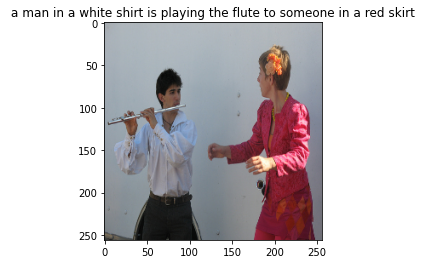

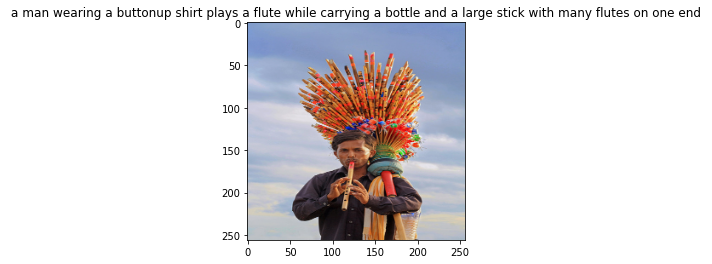

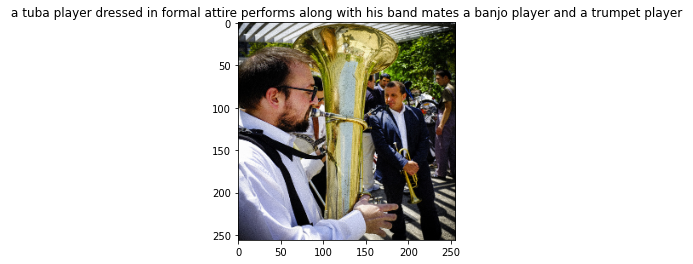

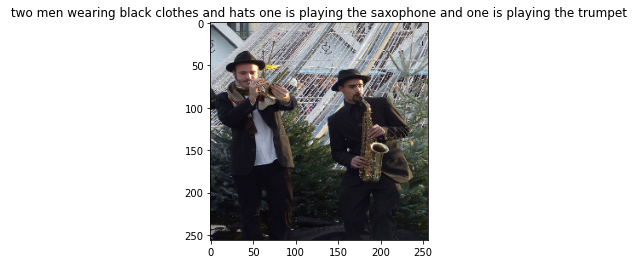

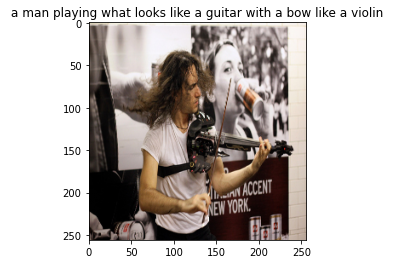

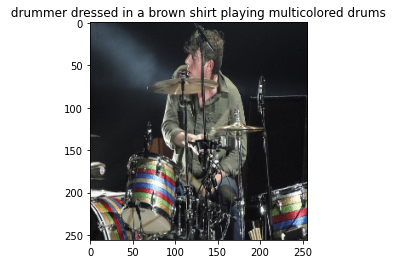

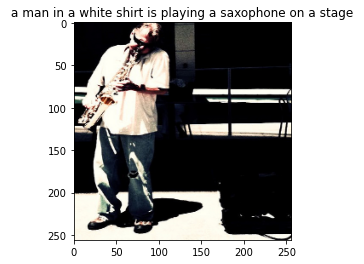

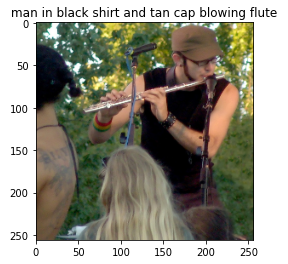

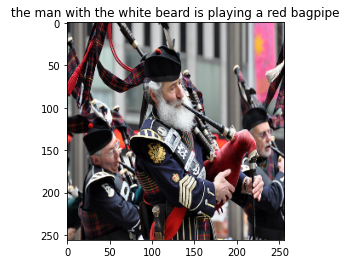

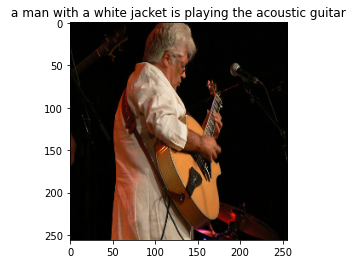

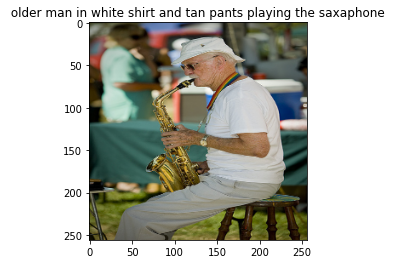

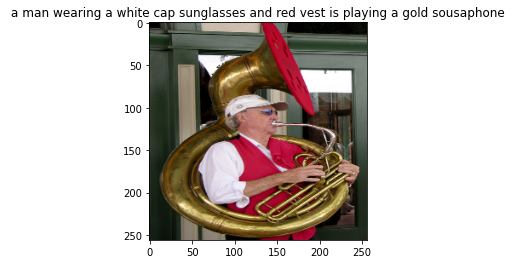

In [365]:
for row in descriptions[descriptions.clusters == 52].values[:20]:
    n = row[0]
    plt.title(row[1])
    plt.imshow( preprocess_img('dataset/database-full/'+n)[0] )
    plt.show()

In [424]:
example = pd.read_csv('examples_of_retrieval.csv', sep="\t")

In [425]:
retrievals=[]
retrievals.append([x.replace(" ", "") for x in example.columns[0].split(",")])
for i in example.index:
    retrievals.append([x.replace(" ", "") for x in example.iloc[i].values[0].split(",")])

In [426]:
retrievals_df = pd.DataFrame(columns=descriptions.columns)
for i, group in enumerate(retrievals):
    cluster = 110 + i
    for name in group:
        retrievals_df = retrievals_df.append({' ID': ' '+name, ' description': '', 'clusters': cluster}, ignore_index=True)

In [370]:
names_to_fix    = retrievals_df[retrievals_df[' ID'].duplicated()][' ID'].unique()

In [371]:
for name_to_fix in names_to_fix:
    clusters_to_join = retrievals_df[retrievals_df[' ID'] == name_to_fix].clusters.values
    rows = retrievals_df[retrievals_df.clusters.isin(clusters_to_join)].index
    retrievals_df.loc[rows, 'clusters'] = clusters_to_join[0]

In [372]:
intersection = []
for x in retrievals_df[' ID'].values:
    if x in descriptions[' ID'].values:
        intersection.append(x)

In [374]:
#renameds_to = []
for x in intersection:
    true_cluster = retrievals_df[retrievals_df[' ID'] == x]['clusters'].values.copy()[0]
    
    #cluster_to_rename = descriptions[descriptions[' ID'] == x].clusters.values.copy()[0]
    #rows = descriptions[descriptions.clusters == cluster_to_rename].index
    
    rows = descriptions[descriptions[' ID'] == x].index
    descriptions.loc[rows, 'clusters'] = true_cluster
    
    
    
    # if(cluster_to_rename in renameds_to):
    #     aux_rows = retrievals_df[retrievals_df.clusters == cluster_to_rename].index
    #     retrievals_df.loc[aux_rows, 'clusters'] = true_cluster
    
    #renameds_to.append(true_cluster)

In [375]:
aux_clusters = pd.concat([descriptions, retrievals_df[~(retrievals_df[' ID'].isin(intersection))]])

In [376]:
aux_clusters = aux_clusters.rename(columns={' ID': 'ID', 'clusters':'cluster'}).drop(' description', axis=1)

In [438]:
map_clusters = dict()
cont = 0
aux_clusters = aux_clusters.reset_index(drop=True)
for i, row in aux_clusters.iterrows():
    
    if(len(aux_clusters[aux_clusters.cluster == row.cluster]) > 1):
        if not row.cluster in map_clusters.keys():
           
            map_clusters[row.cluster] = cont
            cont += 1
        aux_clusters.loc[i, 'new_cluster'] = map_clusters[row.cluster]
    else:
        aux_clusters.loc[i, 'new_cluster'] = -1

In [439]:
aux_clusters.new_cluster = aux_clusters.new_cluster.astype(int)

In [443]:
aux_clusters = aux_clusters[aux_clusters['new_cluster'] != -1]

In [444]:
aux_clusters = aux_clusters.drop_duplicates(keep='first')

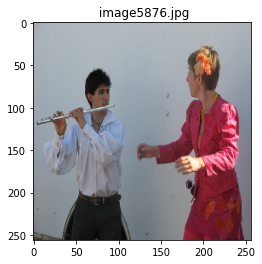

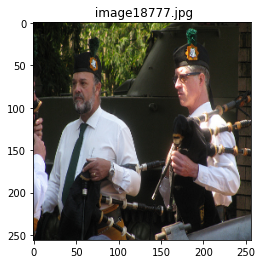

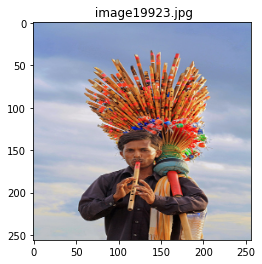

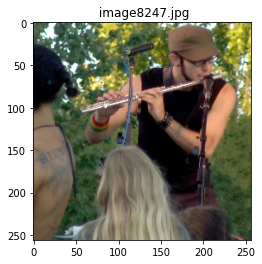

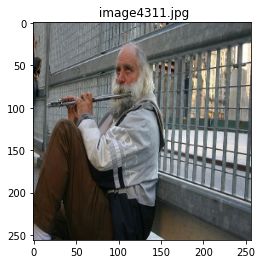

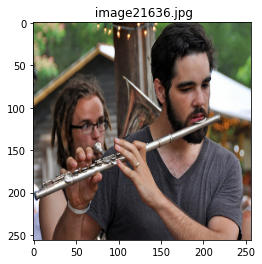

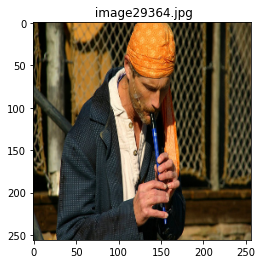

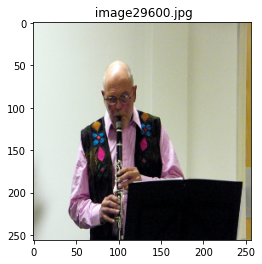

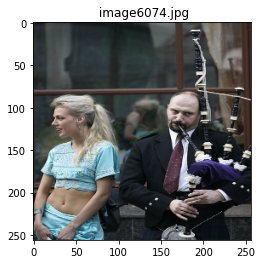

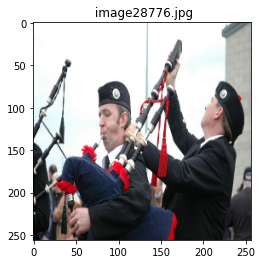

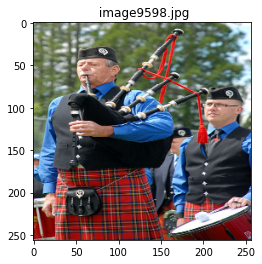

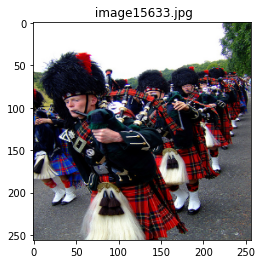

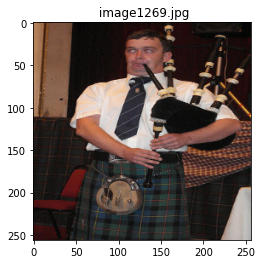

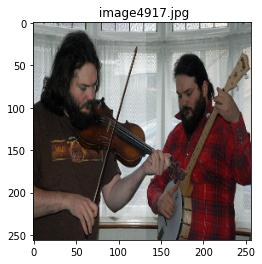

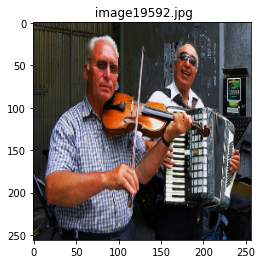

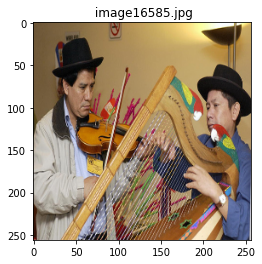

In [446]:
for i, row in aux_clusters[aux_clusters['new_cluster'] == 0].iterrows():
    plt.title(row.ID)
    plt.imshow( preprocess_img('dataset/database-full/'+ row['ID'])[0] )
    plt.show()
    

In [452]:
aux_clusters_final = aux_clusters[['ID', 'new_cluster']]

In [457]:
aux_clusters_final = aux_clusters_final.rename(columns={'new_cluster':'cluster'})

In [459]:
aux_clusters.to_csv('aux_cluster.csv', index=None)